# Использование BERT для задачи классификации последовательности




[Исходный туториал](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) + материалы курса Кати Артемовой  на ФКН

**Важные ссылки про BERT**

[Devlin et al 2019](https://arxiv.org/pdf/1810.04805.pdf) - BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding - статья, презентующая BERT

[Vaswani et al 2017](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) - Attention is all you need - статья, презентующая трансформеры

[Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) by Jay Allamar - архитектура трансформера в картингах и гифках

[Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) by harvardnlp -код трансформера на торче, реализующий статью по абзацам

[Transformers](https://huggingface.co/transformers/) by hugging face -  главная open source библиотека, откуда можно брать предобученные бертоподобные модели


Сегодня посмотрим, как можно использовать BERT (или любую другую подобную модель) с помощью библиотеки Transformers.

Общий пайплайн:
BERT используется как начальный блок модели и считает контекстные вектора для слов.
Поверх этого блока мы добавляем "голову" модели, ее архитектура зависит от задачи.
Веса BERT предобучены, но мы проводим дообучение (fine-tuning) на целевой задаче.




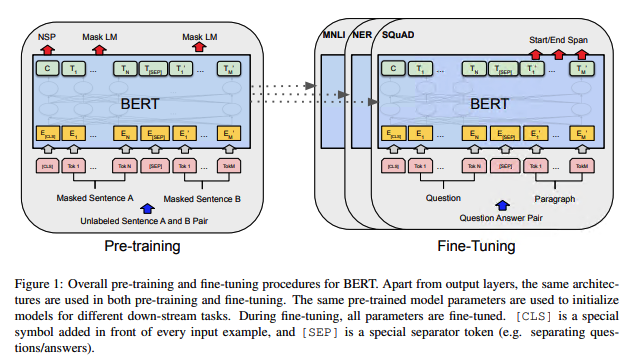

Наша сегодняшняя задача - классификация отзывов.
Данные - отзывы на приложения в Google Play, классы:  negative (1,2), neutral (3), positive (4,5) 

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face 

In [1]:
!pip install -q -U watermark

In [2]:
!pip install transformers

     |████████████████████████████████| 2.0MB 8.7MB/s 
     |████████████████████████████████| 890kB 45.2MB/s 
     |████████████████████████████████| 3.2MB 48.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=432beab1ffb5074a105fb98970682aa98210a202874806494e30f7a602ed96e9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.0+cu101
transformers: 4.4.2



Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 41.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 113MB/s]


In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [7]:
df = pd.read_csv("reviews.csv")
# print("Количество примеров: ", df.shape[0])
# df.head()

In [8]:
df.shape

(15746, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [10]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


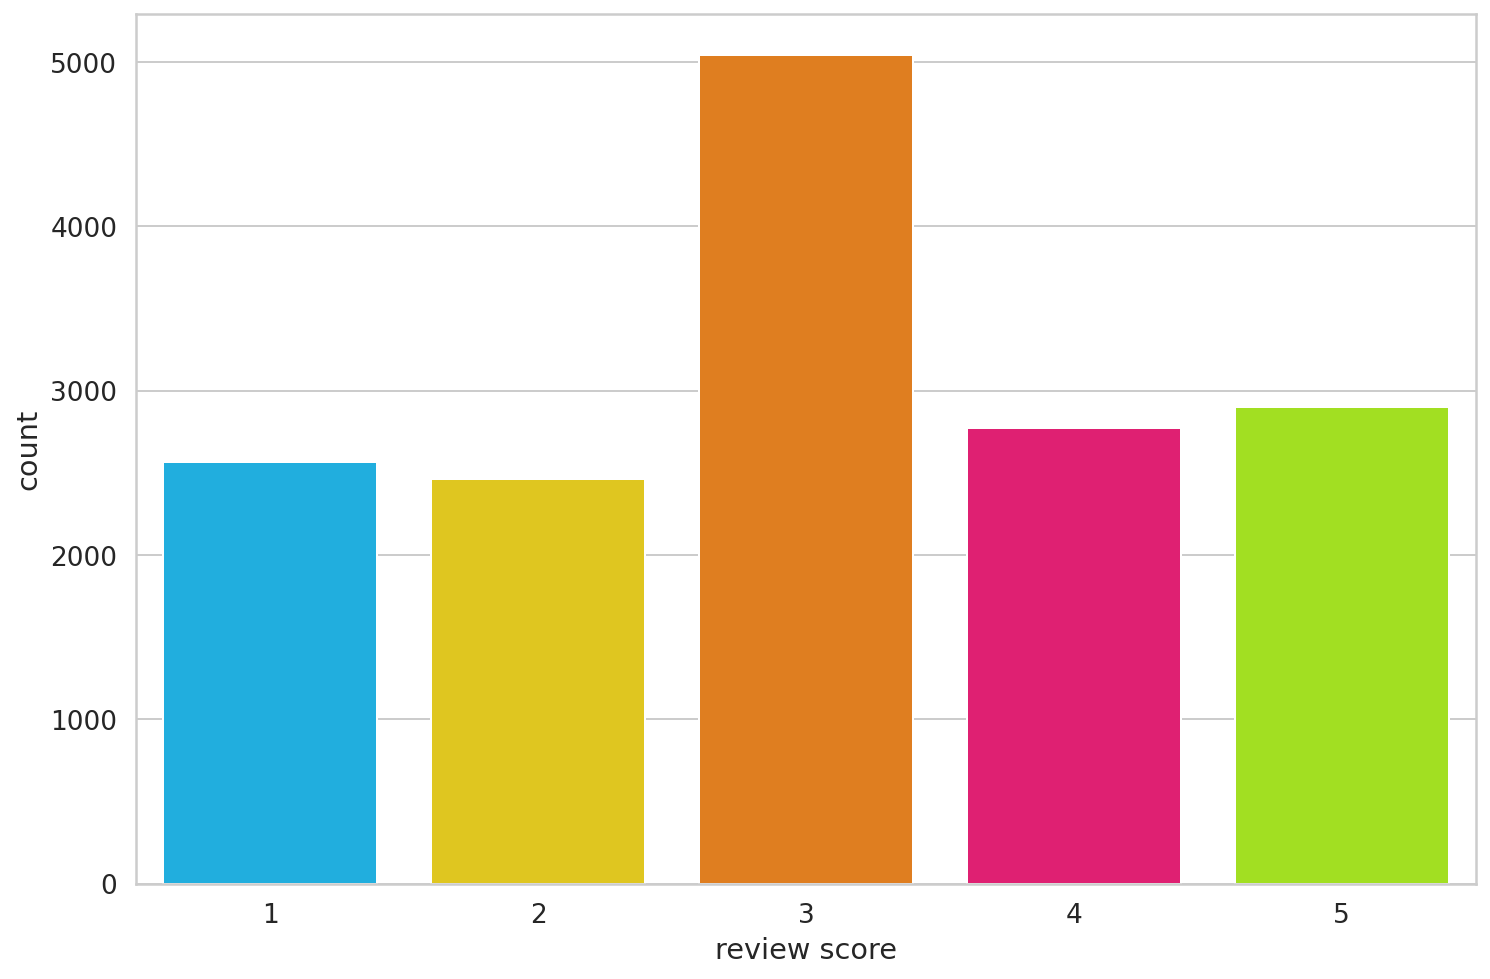

In [11]:
sns.countplot(df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы. 
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [12]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [13]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


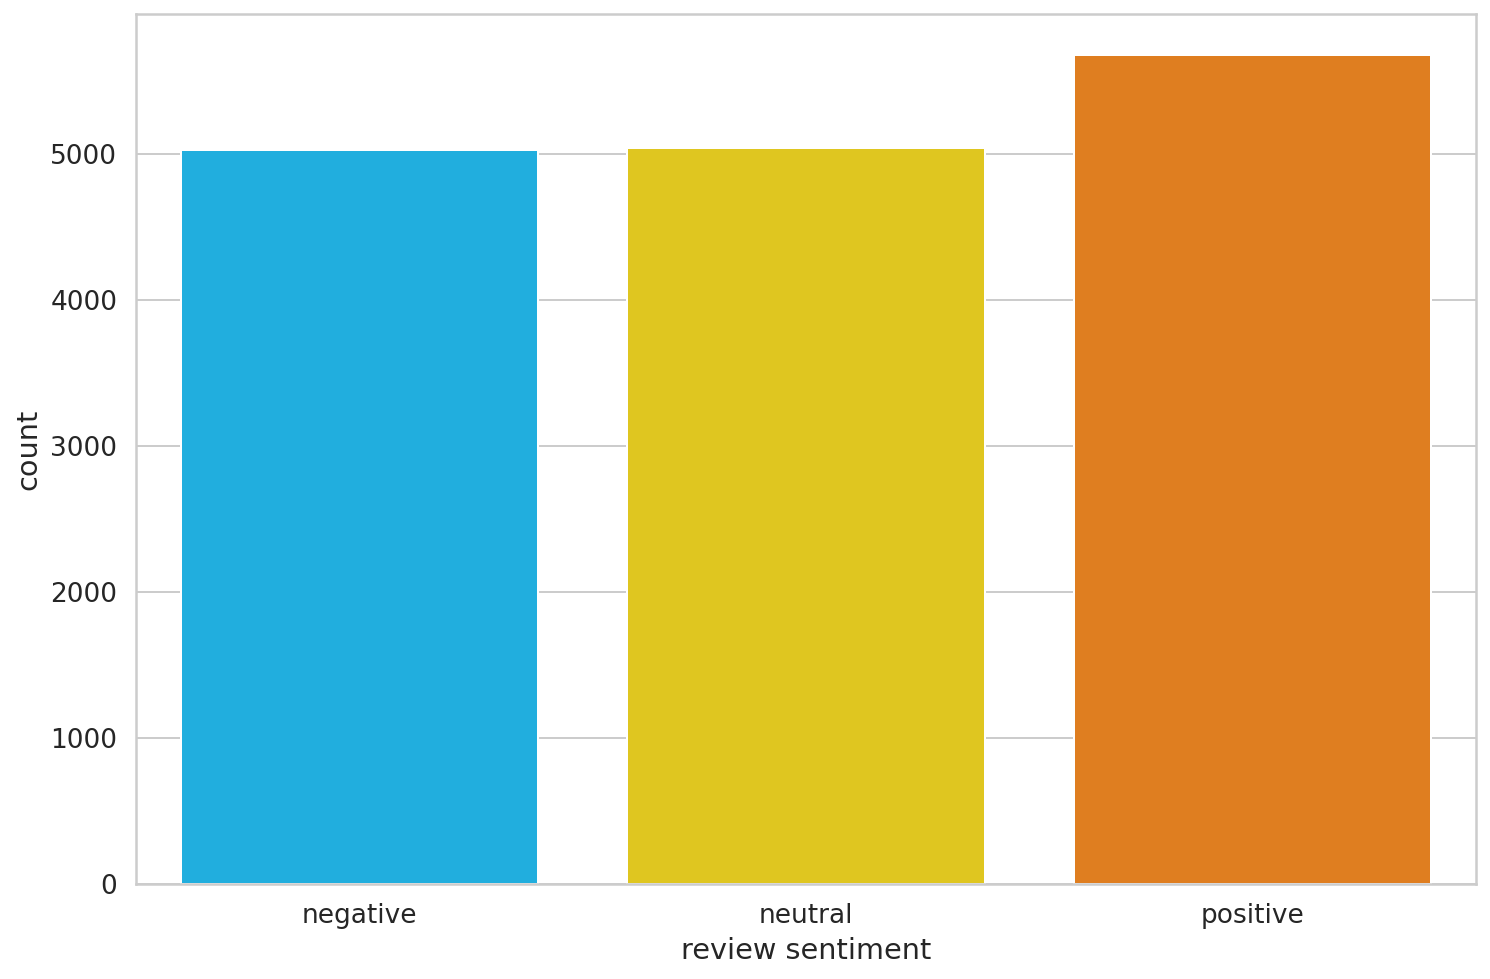

In [14]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

## Предобработка данных

Для обучение модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.



Бертоподобных моделей огромное множество, но если они интегрированы в библиотеку Transformers, сменить одну модель на другую очень просто. Вот [здесь](https://huggingface.co/transformers/pretrained_models.html) можно посмотреть, какие модели есть библиотеке. 

Model id в таблице используются для двух вещей - подгрузки весов в саму модель и подгрузки правильного токенизатора. Вам не нужно самим добавлять спецсимволы и строить индексы словаря, это сделает токенайзер, соотвествующий выбранной модели.
Сегодняшний выбор - модель 'bert-base-cased'

In [15]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Посмотрим, как работает модель токенизации для BERT.



In [17]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [18]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: He started a new book, it was quite readable
   Tokens: ['He', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able']
Token IDs: [1124, 1408, 170, 1207, 1520, 117, 1122, 1108, 2385, 2373, 1895]


##  Специальные токены

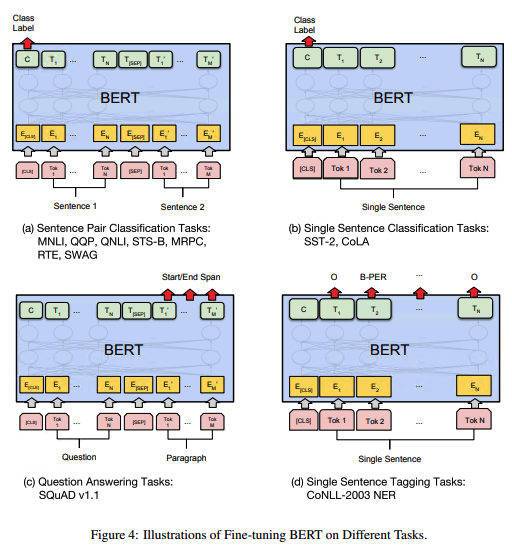



`[SEP]` - метка конца предложения


In [19]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [20]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [21]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Кроме того, существует специальный токен для неизвестных слов, которые не встречались в обучающей выборке

In [22]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Вся эта предобработка может быть сделана с помощью метода encode_plus

In [23]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  # pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Такая же длина будет и у *attention mask*

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['[CLS]',
 'He',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Установим максимальную длину последовательности равной 160

In [27]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [28]:

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки 

In [29]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [31]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

Для обработки данных нам также нужно будет создать итераторы 
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [34]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [35]:
data = next(iter(train_data_loader))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [36]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Классификация сентимента с использованием модели BERT от Hugging Face


В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [38]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Попробуем использовать эту модель 

In [39]:
encoding['input_ids']

tensor([[ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [40]:
last_hidden_state, pooled_output = bert_model( 
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
,return_dict=False)


В переменную last_hidden_state теперь записана последовательность скрытых состояний последнего слоя модели. 

In [41]:
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


Посмотрим на BERT эмбеддинги некоторых слов в предложениях.

In [42]:
df.loc[16]['content']

"Couldn't even set up one single recurring reminder without being required to pay monthly subscription. Get your greedy hand off it dev. It's only only a reminder app not a useful service."

In [43]:
sample_txt = df.loc[16]['content']

In [44]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [45]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict=False)

In [46]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [47]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Couldn', "'", 't', 'even', 'set', 'up', 'one', 'single', 'recurring', 'reminder', 'without', 'being', 'required', 'to', 'pay', 'monthly', 'subscription', '.', 'Get', 'your', 'greedy', 'hand', 'off', 'it', 'de', '##v', '.', 'It', "'", 's', '[SEP]']


In [48]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')

17

In [49]:
emb0 = last_hidden_state[0, 17]
emb0.shape

torch.Size([768])

In [50]:
df.loc[338]['content']

'Well designed and all however alot of the crutial features are locked behind the premium which u need to pay for'

In [51]:
sample_txt = df.loc[338]['content']
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)
result = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)
last_hidden_state, pooled_output  = result.last_hidden_state, result.pooler_output 

In [52]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('premium')

18

In [53]:
emb1 = last_hidden_state[0, 18]
emb1.shape

torch.Size([768])

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

In [55]:
cosine_similarity( [emb0.detach().cpu().numpy()], [emb1.detach().cpu().numpy()])

array([[0.7258624]], dtype=float32)

Опишем наконец наш классификатор на основе BertModel

In [56]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [57]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [58]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

Перенесем на GPU один из наших батчей (для примера).

In [59]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


Чтобы получить вероятности классов, мы применим SoftMax к выходу модели.

In [60]:
import torch.nn.functional as F

In [61]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3642, 0.2756, 0.3602],
        [0.5087, 0.1956, 0.2957],
        [0.3486, 0.3318, 0.3195],
        [0.2949, 0.2083, 0.4968],
        [0.3327, 0.1832, 0.4841],
        [0.4826, 0.2452, 0.2723],
        [0.3839, 0.1533, 0.4628],
        [0.5541, 0.2191, 0.2268],
        [0.5205, 0.1811, 0.2984],
        [0.3006, 0.1879, 0.5115],
        [0.5273, 0.2709, 0.2017],
        [0.4166, 0.3426, 0.2408],
        [0.5826, 0.1546, 0.2629],
        [0.4702, 0.1446, 0.3852],
        [0.5306, 0.1897, 0.2797],
        [0.3464, 0.2752, 0.3784]], grad_fn=<SoftmaxBackward>)

## Обучение модели

Для дообучения модели будем использовать оптимайзер [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face. 



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [63]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения

In [64]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Также реализуем функцию для оценки качества модели на данных из data_loader

In [65]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели 

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.7252750147815213 accuracy 0.6710888434126032
Val loss 0.5537333291769028 accuracy 0.7662007623888183

Epoch 2/2
----------



При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы. 

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы. 

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


# Использование BERT для задачи классификации последовательности




[Исходный туториал](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) + материалы курса Кати Артемовой  на ФКН

**Важные ссылки про BERT**

[Devlin et al 2019](https://arxiv.org/pdf/1810.04805.pdf) - BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding - статья, презентующая BERT

[Vaswani et al 2017](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) - Attention is all you need - статья, презентующая трансформеры

[Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) by Jay Allamar - архитектура трансформера в картингах и гифках

[Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) by harvardnlp -код трансформера на торче, реализующий статью по абзацам

[Transformers](https://huggingface.co/transformers/) by hugging face -  главная open source библиотека, откуда можно брать предобученные бертоподобные модели


Сегодня посмотрим, как можно использовать BERT (или любую другую подобную модель) с помощью библиотеки Transformers.

Общий пайплайн:
BERT используется как начальный блок модели и считает контекстные вектора для слов.
Поверх этого блока мы добавляем "голову" модели, ее архитектура зависит от задачи.
Веса BERT предобучены, но мы проводим дообучение (fine-tuning) на целевой задаче.




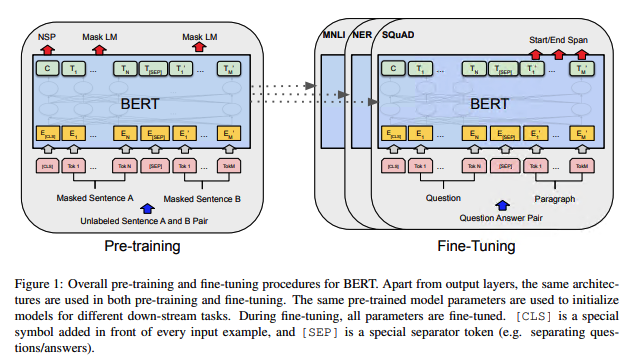

Наша сегодняшняя задача - классификация отзывов.
Данные - отзывы на приложения в Google Play, классы:  negative (1,2), neutral (3), positive (4,5) 

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face 

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.0+cu101
transformers: 4.4.1



Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 38.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.0MB/s]


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
df = pd.read_csv("reviews.csv")
# print("Количество примеров: ", df.shape[0])
# df.head()

In [ ]:
df.shape

(15746, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

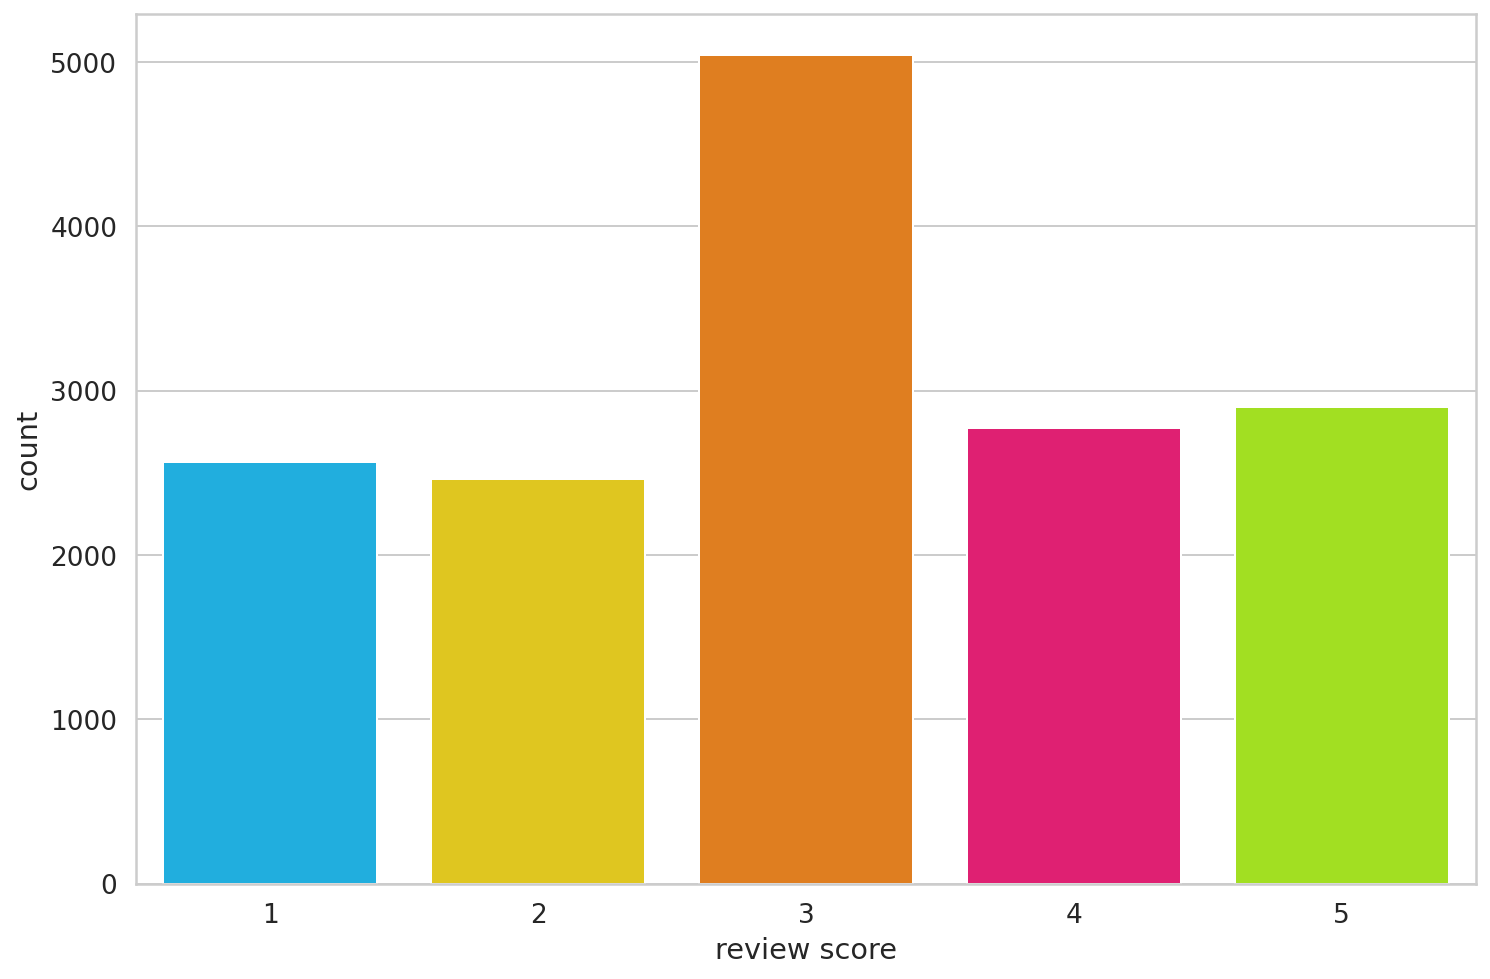

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы. 
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

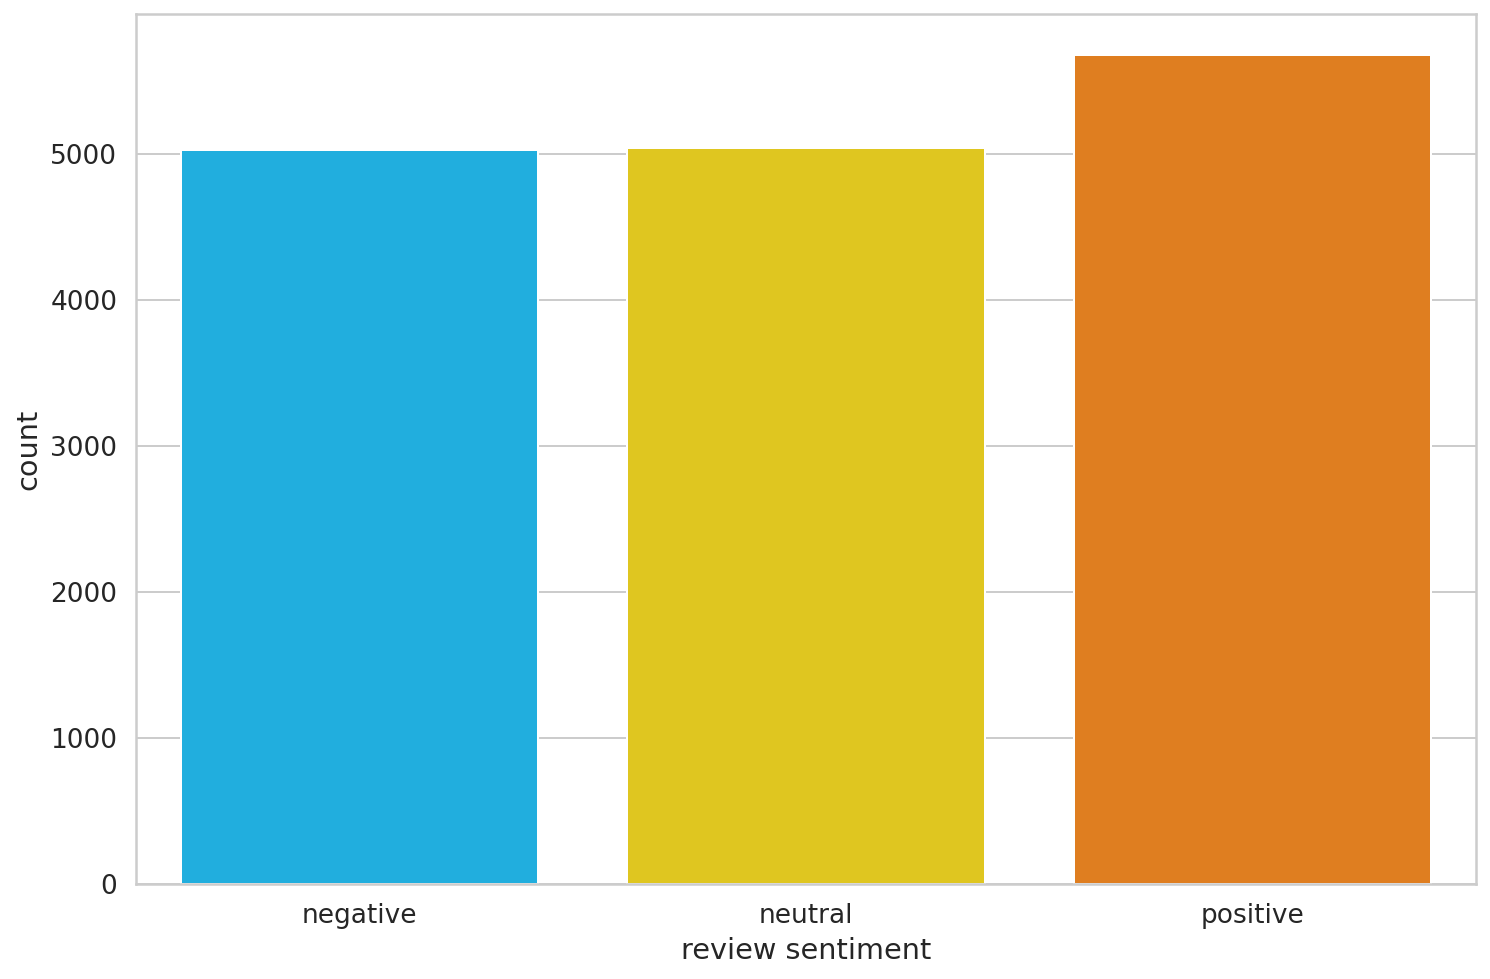

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

## Предобработка данных

Для обучение модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.



Бертоподобных моделей огромное множество, но если они интегрированы в библиотеку Transformers, сменить одну модель на другую очень просто. Вот [здесь](https://huggingface.co/transformers/pretrained_models.html) можно посмотреть, какие модели есть библиотеке. 

Model id в таблице используются для двух вещей - подгрузки весов в саму модель и подгрузки правильного токенизатора. Вам не нужно самим добавлять спецсимволы и строить индексы словаря, это сделает токенайзер, соотвествующий выбранной модели.
Сегодняшний выбор - модель 'bert-base-cased'

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Посмотрим, как работает модель токенизации для BERT.



In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: He started a new book, it was quite readable
   Tokens: ['He', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able']
Token IDs: [1124, 1408, 170, 1207, 1520, 117, 1122, 1108, 2385, 2373, 1895]


##  Специальные токены

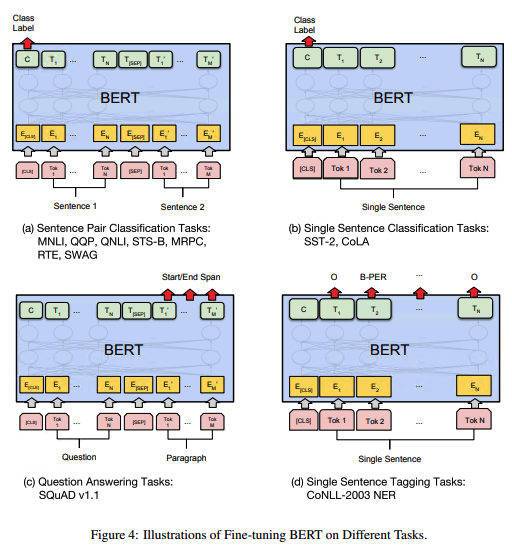



`[SEP]` - метка конца предложения


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Кроме того, существует специальный токен для неизвестных слов, которые не встречались в обучающей выборке

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Вся эта предобработка может быть сделана с помощью метода encode_plus

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  # pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Такая же длина будет и у *attention mask*

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['[CLS]',
 'He',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Установим максимальную длину последовательности равной 160

In [ ]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки 

In [ ]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

Для обработки данных нам также нужно будет создать итераторы 
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [ ]:
data = next(iter(train_data_loader))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Классификация сентимента с использованием модели BERT от Hugging Face


В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Попробуем использовать эту модель 

In [ ]:
encoding['input_ids']

tensor([[ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
last_hidden_state, pooled_output = bert_model( 
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
,return_dict=False)


В переменную last_hidden_state теперь записана последовательность скрытых состояний последнего слоя модели. 

In [ ]:
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


Посмотрим на BERT эмбеддинги некоторых слов в предложениях.

In [ ]:
df.loc[16]['content']

"Couldn't even set up one single recurring reminder without being required to pay monthly subscription. Get your greedy hand off it dev. It's only only a reminder app not a useful service."

In [ ]:
sample_txt = df.loc[16]['content']

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict=False)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Couldn', "'", 't', 'even', 'set', 'up', 'one', 'single', 'recurring', 'reminder', 'without', 'being', 'required', 'to', 'pay', 'monthly', 'subscription', '.', 'Get', 'your', 'greedy', 'hand', 'off', 'it', 'de', '##v', '.', 'It', "'", 's', '[SEP]']


In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')

17

In [ ]:
emb0 = last_hidden_state[0, 17]
emb0.shape

torch.Size([768])

In [ ]:
df.loc[338]['content']

'Well designed and all however alot of the crutial features are locked behind the premium which u need to pay for'

In [ ]:
sample_txt = df.loc[338]['content']
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)
result = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)
last_hidden_state, pooled_output  = result.last_hidden_state, result.pooler_output 

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('premium')

18

In [ ]:
emb1 = last_hidden_state[0, 18]
emb1.shape

torch.Size([768])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity( [emb0.detach().cpu().numpy()], [emb1.detach().cpu().numpy()])

array([[0.7258624]], dtype=float32)

Опишем наконец наш классификатор на основе BertModel

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

Перенесем на GPU один из наших батчей (для примера).

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


Чтобы получить вероятности классов, мы применим SoftMax к выходу модели.

In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4484, 0.4185, 0.1331],
        [0.2468, 0.4027, 0.3504],
        [0.2357, 0.5070, 0.2573],
        [0.2193, 0.4941, 0.2866],
        [0.3516, 0.3043, 0.3441],
        [0.2224, 0.4461, 0.3315],
        [0.3609, 0.3796, 0.2595],
        [0.1716, 0.5991, 0.2293],
        [0.1612, 0.4984, 0.3403],
        [0.2330, 0.4487, 0.3183],
        [0.4166, 0.3401, 0.2434],
        [0.3402, 0.3418, 0.3180],
        [0.1919, 0.3706, 0.4376],
        [0.2796, 0.4074, 0.3130],
        [0.2514, 0.3591, 0.3895],
        [0.2909, 0.2929, 0.4162]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Обучение модели

Для дообучения модели будем использовать оптимайзер [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face. 



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [ ]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Также реализуем функцию для оценки качества модели на данных из data_loader

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели 

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.7340290353509428 accuracy 0.6703831769105921
Val loss 0.5544602817296982 accuracy 0.7636594663278272

Epoch 2/2
----------
Train loss 0.4343223484447457 accuracy 0.833674405475972
Val loss 0.5247003095597029 accuracy 0.8081321473951716

CPU times: user 13min 33s, sys: 12min 56s, total: 26min 29s
Wall time: 26min 34s



При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

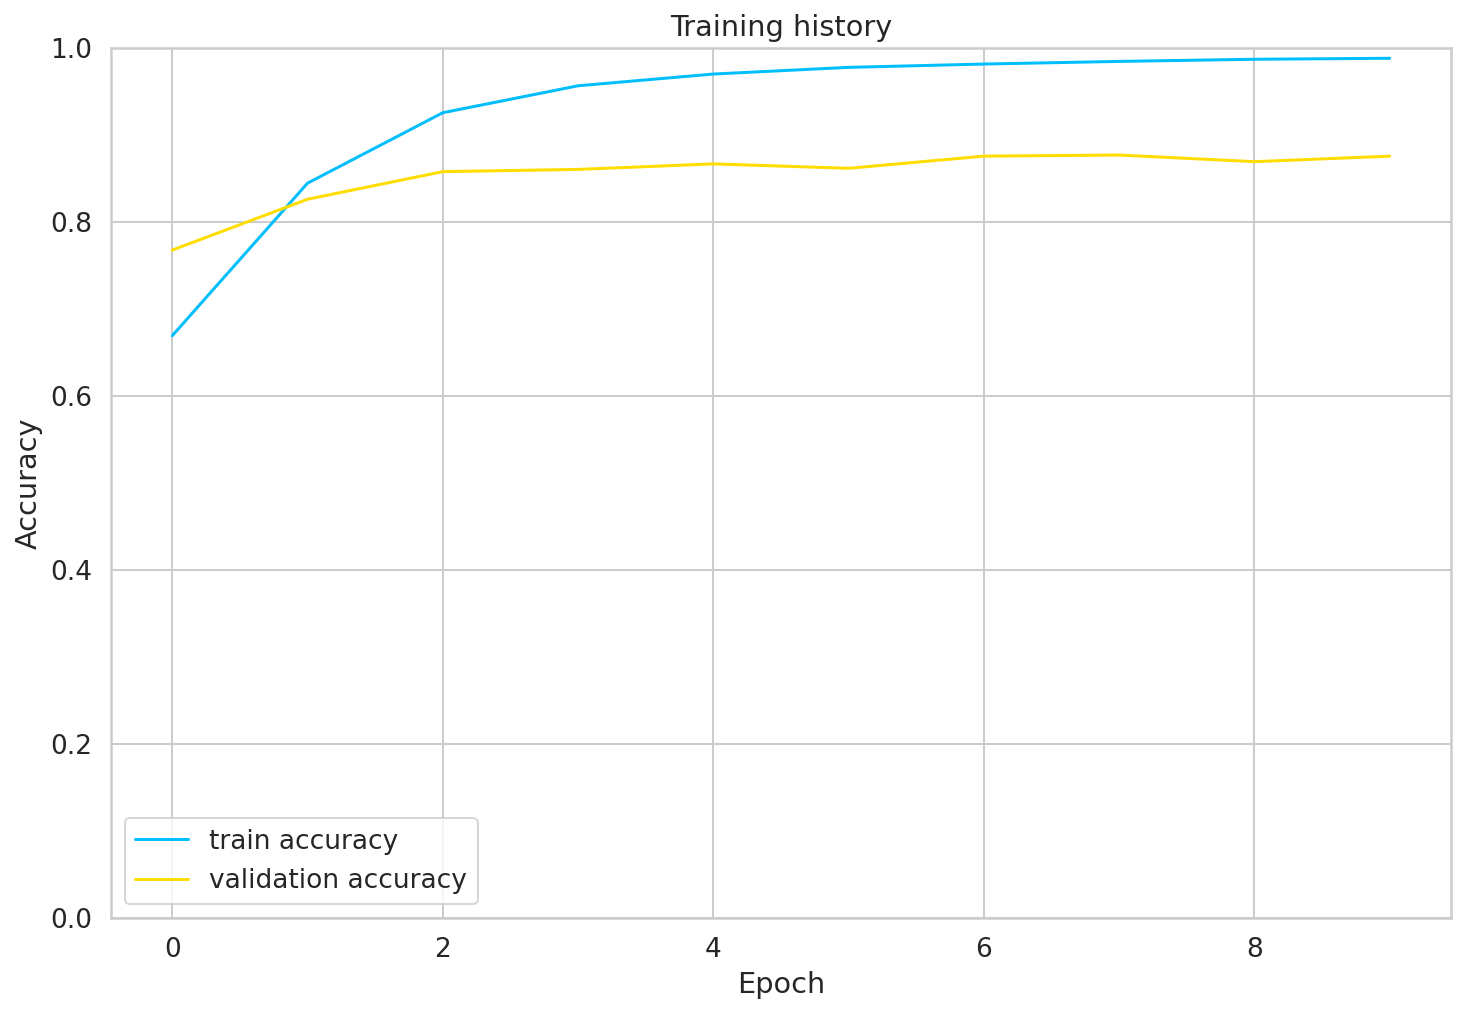

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Из графика видно, что доля правильных ответов модели при обучении приближается к 100% после приблизительно 10 эпох.

In [ ]:
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8895939086294415

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.85      0.88       245
     neutral       0.82      0.88      0.85       254
    positive       0.93      0.93      0.93       289

    accuracy                           0.89       788
   macro avg       0.89      0.89      0.89       788
weighted avg       0.89      0.89      0.89       788



Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы. 

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

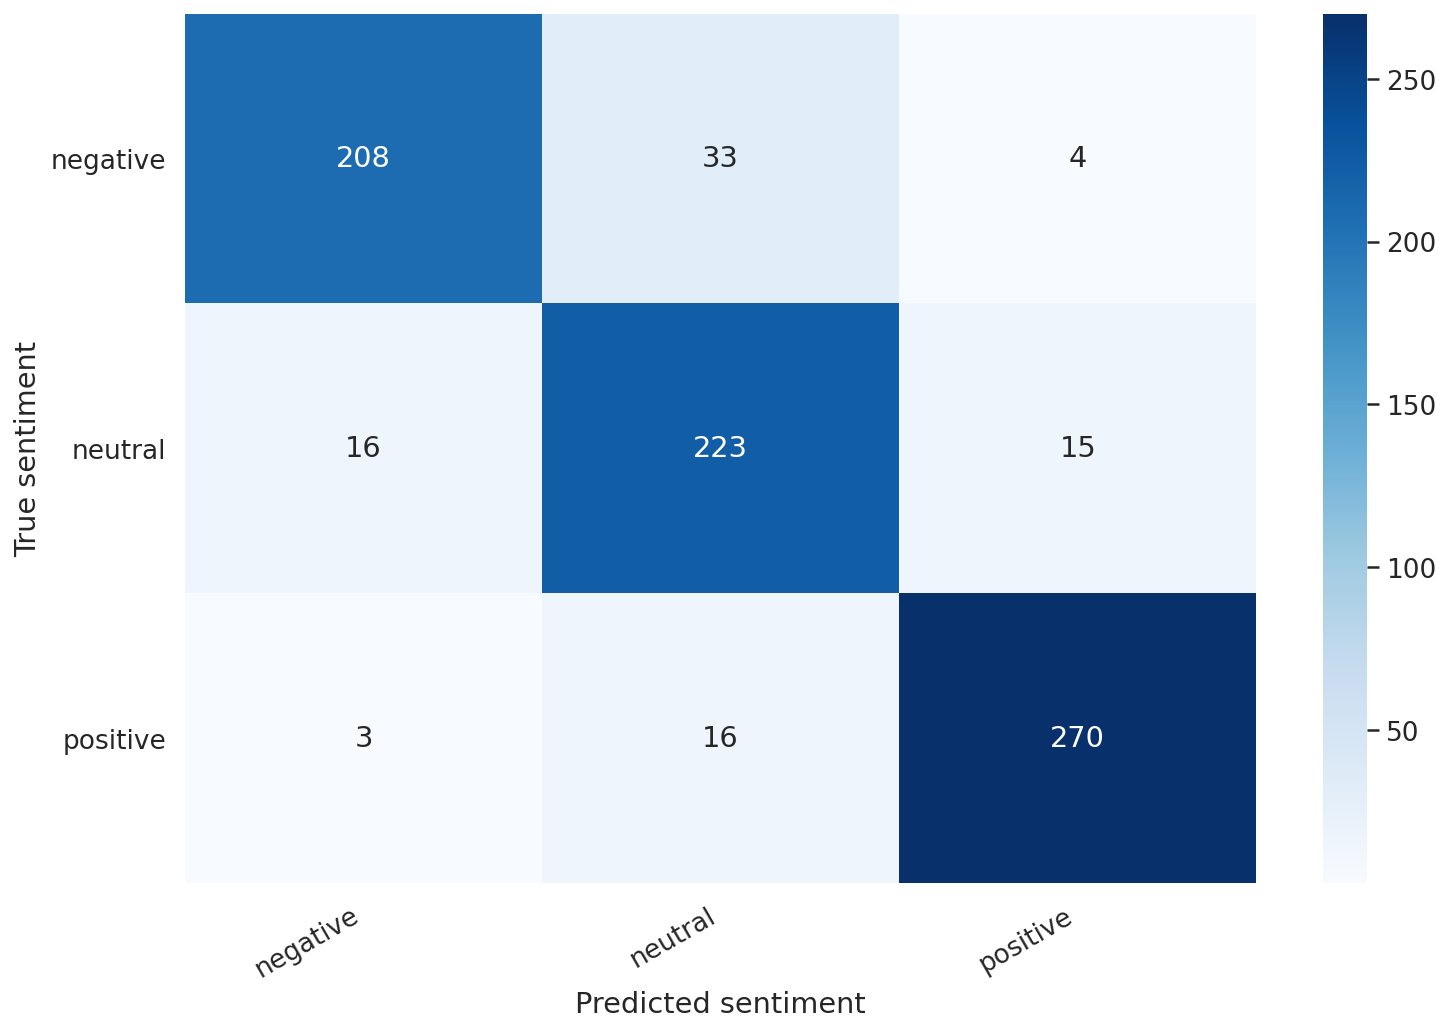

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы. 

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
